Complete the assignment and turn it in to D2L by **_11:59pm on Sunday, February 23_**.

# Homework 2: Image Processing using OMP

In this assignment, you are going to modify and improve the processing speed of an edge detector for grayscale PNG images. Edge detection is an image processing technique to find boundaries of objects in images. Here is an example image and the detected edges:

**Note:** this homework was motivated and adapted from: https://web.stanford.edu/class/cs315b/assignment1.html

<table>
    <tr><td>
<img src="https://lh3.googleusercontent.com/KAUNwCSj6OGz-XCnH8vtA0zoxtiWhlw67IYzULXvfH37ap5JYz46i8TMU-mM4x7-dkOuc3hgUA=w740" alt="Example image of Sparty"></td><td><img src="https://lh4.googleusercontent.com/goBSqfFUUXwKaeVBJEm3zdwzQZLokNZBTEbDx8GE-axIB3EaLURys7bcFhPT89r2CKN0e87BHQ=w740" alt="Example edge detection taken of the Sparty Image"></td></tr>

The files necessary for this assignment are found in a zip folder titled "HW2_edge_detection.zip".  To turn in this assignment you must upload all files to D2L.  Use the following instructions:
    

&#9989; **<font color=red>DO THIS:</font>** Upload the code files to you HPCC account and make sure you can compile and run the software.  Note, this program uses the libpng library which is already installed on the HPCC. 
    
1. Download the [Edge_Detection repository](https://d2l.msu.edu/d2l/le/content/2225524/viewContent/17191154/View) repository from the "Homework Files" section on D2L under "Content". Once downloaded, add it to your course Github repository. 
2. Pull your updated repository with the "Edge Detection" folder to your account on the HPCC.
3. From a command line move into the repository and run the following commands to verify the code is working:
```bash
make
make test
```
4. To complete the assignment, submit all files to the D2L submission box by **_11:59pm on Sunday, February 23_** 
 
**_Note:_** if for any reason you can not figure out git, please review the [git tutorial](https://msu-cmse-courses.github.io/cmse802-f20-student/0000-Getting-to-know-git.html) and go to your instructors office hours. 

### Goals for this assignment:

By the end of this assignment, you should be able to:

* Practice using Git
* Debug and benchmark existing workflows.
* Use OpenMP to run code in parallel.


# Code Description and Background 

There are lots of edge detection algorithms but in this assignment, you will work on an algorithm with the following three steps:

1. Image Smoothing
2. Gradient calculation (Sobel Filters)
3. Edge Thresholding

The following section describes each step in detail.

### Step 1: Smoothing (Average vs Median Filtering)
Before starting the actual edge detection, we smooth the image to reduce undesired edges detected due to noise. There are lots of ways to smooth an image. The code provided uses an Average Filter.  Average Filtering approaches uses a "sliding window algorithm".  The input and outputs of a "sliding window algorithm" is an image.  The value of each pixel in the output image is calculated using a "window" of data around the corresponding pixel in the input image.  

For the **Average Filter**, all of the pixels in the window for are averaged and the value is stored in the output image at the same location as the center pixel. 

If you think about it, the sliding window is not fully defined at the edges.  For the Average Filter this is not a problem. The algorithm just takes the median or average of the valid points within the windows. Here is a snip-it from the code:

```C++
//Average Filter 
for(int c=0;c<sz.width;c++) 
    for(int r=0;r<sz.height;r++)
    {
        double count = 0;
        double tot = 0;
        for(int cw=max(0,c-halfwindow); cw<min(sz.width,c+halfwindow+1); cw++)
            for(int rw=max(0,r-halfwindow); rw<min(sz.height,r+halfwindow+1); rw++)
            {
                count++;
                tot += (double) img[rw][cw];
            }
        output[r][c] = (int) (tot/count);
    }

```

### Step 2: Gradient calculation (Sobel Filter)

Assuming that each object consists of pixels that do not greatly vary in their brightness, the edges in an image are from the sudden changes of brightness in the pixels.  One way to measure how big the change is to calculate the gradient magnitude at each pixel. The gradient operator we are going to use in this assignment is Sobel operator. Sobel operator is based on the following two 3x3 filters, which calculate x and y component of the gradient, respectively:

$$ G_x =
\left[
\begin{matrix}
    -1   & 0 & 1  \\
    -2   & 0 & 2  \\
    -1   & 0 & 1 
 \end{matrix}
 \right]
 G_y = 
\left[
\begin{matrix}
    1   & 2 & 1  \\
    0   & 0 & 0  \\
    -1 & -2 & -1 
 \end{matrix}
 \right]
$$

Here is a code snip-it that creates the filters:

```c++
//Sobel Filters
double xfilter[3][3];
double yfilter[3][3];
xfilter[0][0] = -1;
xfilter[1][0] = -2;
xfilter[2][0] = -1;
xfilter[0][1] = 0;
xfilter[1][1] = 0;
xfilter[2][1] = 0;
xfilter[0][2] = 1;
xfilter[1][2] = 2;
xfilter[2][2] = 1;
for(int i=0;i<3;i++) 
    for(int j=0;j<3;j++)
        yfilter[j][i] = xfilter[i][j];

```

Once x and y components of the gradient is computed, the magnitude can be computed by: 

$$IMG_{Gradient} = \sqrt{G_x^2 + G_y^2}$$



```C++
// Gradient Filter
for(int c=1;c<sz.width-1;c++)
    for(int r=1;r<sz.height-1;r++)
        {
                double Gx = 0;
                double Gy = 0;
                for(int cw=0; cw<3; cw++)
                    for(int rw=0; rw<3; rw++)
                        {
                                Gx +=  ((double) output[r+rw-1][c+cw-1])*xfilter[rw][cw];
                                Gy +=  ((double) output[r+rw-1][c+cw-1])*yfilter[rw][cw];
                        }
                g_img[r][c] = sqrt(Gx*Gx+Gy*Gy);
        }
```

### Step 3: Edge Thresholding

The last step in the code provided is edge thresholding.  In this case, edges are defined based on the gradient image ($IMG_{Gradient}$).  Values over the threshold are considered edges and vales under the threshold are not edges.

$$IMG_{Edge} = IMG_{Gradient} > thresh$$

The threshold (```thresh```) may be varied to get different results.  For the images provided set the threshold to be 50. 


```C++
// Thresholding
for(int c=0;c<sz.width;c++)
    for(int r=0;r<sz.height;r++)
    if (g_img[r][c] > thresh)
        output[r][c] = 255;
    else
        output[r][c] = 0;
```

# Homework Assignment

For this assignment you will do the following parts:

1. Establish Serial Benchmark
2. Optimize the Serial Code using compiler options
3. Modify the code to use OpenMP loops
4. Final Report
5. Deliverables

## Part 1: Establish Serial Benchmark

&#9989; **<font color=red>DO THIS:</font>** Benchmark the code provided using the image files provided in the images directory.  This file should provide a solid baseline.  Make sure you explicitly describe the hardware you ran on and run enough trials to account for hardware and system variation.

## Part 2: Optimize the Serial Code using compiler options
The code provided is not optimized very well.  There are lots of things that could be done to speed up the existing code. For this homework I would like you try and benchmark two optimizations:

1. Use different levels of compiler optimization 
1. Change the order of the loops (row and column) for the Average Filter, Gradient Filter and Edge Thresholding. See if the change in order will increase speed due to multiple cache hits. 

&#9989; **<font color=red>DO THIS:</font>** Make the updates to the serial code as described above.  Benchmark and compare the time differences between the original version, the modified versions.  Pick the changes that provide for the fastest code.  Make all comparisons on the same hardware as Part #1.  If possible provide a detailed table or graph to show the differences. 

Make sure you also save a version of your best serial code to turn in. 

## Part 3: Modify the code to use OpenMP loops

&#9989; **<font color=red>DO THIS:</font>** Rewrite the code to use OpenMP loops to run the Average Filter, Gradient Filter and Edge Thresholding in parallel.  Make sure you carefully note the types of changes you make and use proper synchronization.  Benchmark your changes with different OMP Loop Scheduling options and compare to the serial benchmarks.

### OMP Loop Scheduling Options
Watch the following video which talks about ways to play around with schedulign options:

* &#9989; **<font color=red>DO THIS:</font>** Watch the Scheduling [Introduction to OpenMP: 10 Discussion 4](https://www.youtube.com/watch?v=8jzHiYo49G0)  video:

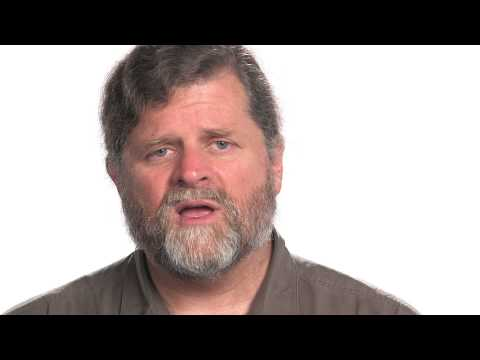

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("8jzHiYo49G0",width=570,height=360)

>**schedule(static [,chunk])** Deal-out blocks of interations of size "chunk" to each thread
> 
>**schedule(dynamic[,chunk])** Each thread grabs "chunk" Iterations off a queue until all iterations have been handeled.
> 
>**schedule(guided[,chunk])** Threads dynamically grab blocks of iterations. The size of the block starts large and shrinks down to size "chnunk" as the calculation proceeds.
> 
>**schedule(runtime)** Schedule and chunk size taken from OMP_SCHEDULE enviornment variable (or the runtime library).
> 
>**schedule(auto)** Schedule is left up to the runtime to choose (does not have to be any of the above).

/var/folders/33/7pv31c616blfz79b49cpd6ph0000gp/T/ipykernel_2725/721397745.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filename)


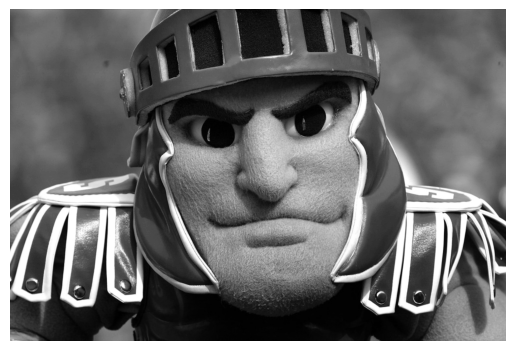

In [14]:
# Code for loading png images in python
# feel free to load two different version of an edge file, subtract them and compare the difference
# This can be very good when you try to debug. 
%matplotlib inline
import matplotlib.pylab as plt
import imageio

filename = 'edge_detection-master/images/sparty.png'

im = imageio.imread(filename)
    
#Show the image
plt.imshow(im, cmap='gray');
plt.axis('off');
plt.show();

## Part 4: Final Report

&#9989; **<font color=red>DO THIS:</font>** Write a report describing what you learned (There is a template in the instructor's git repository).  This report should be in the form of a narrative (story).  Start by describing how the provided serial code performed and what you did to accurately measure that performance. Then talk about what you did to optimize the serial performance. Finally, describe what you did to add in OpenMP and how the different scheduling options changed the speed of the algorithm.  Make sure you include well labeled graphs of all of your benchmarking data and explain the graphs in your report text with a focus on any odd results you may see.  Conclude with a general lessons learned.

This is an image algorithm. You should include example images. 


### Grayscale PNG images
The code provided is desinged to work only with grayscale ```*.png```  images. Most PNG images are color and many images are in different formats (ex. TIFF, jpeg).  Fortunatly there is an easy to use command called ```convert``` which comes with the [ImageMagick](https://www.imagemagick.org/) Library. Feel free to download and install the software for your own use or use the software already installed on the HPCC.  The following examples can be used on the HPCC to load ImageMagick into your PATH, download an image from the internet and convert the image to a grayscale ```PNG``` file:

```bash
module load ImageMagick
wget https://c1.staticflickr.com/7/6118/6369769483_882a704a38_b.jpg
convert -colorspace Gray 6369769483_882a704a38_b.jpg MSUStadium.png
```

## Part 5: Deliverables

&#9989; **<font color=red>DO THIS:</font>** Prepare your files for the instructor.  I recommend having three versions of the code; original serial version, optimized serial version, optimized OMP version.  Update the provided ```Makefile``` to build all three executables. The files should include.

When you are done, add/commit and push all of your changes to your forked git repository. Your instructor will use the following command to compile and test your code on the HPCC:

    make clean
    make 
    make test

Watch the following videos for some hints to help streamline your code and benchmarking process:

&#9989; **<font color=red>DO THIS:</font>** Environment Variables in OpenMP [Introduction to OpenMP: 11 part 4 Module 6](https://www.youtube.com/watch?v=WXqicIq68-s) 
 

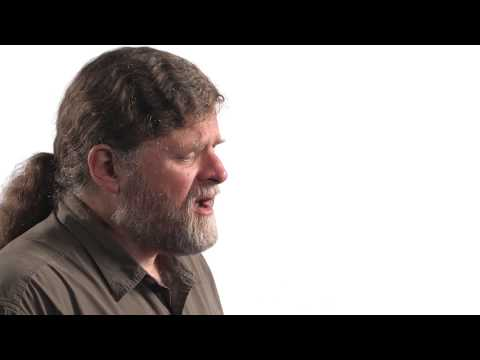

In [37]:
from IPython.display import YouTubeVideo
YouTubeVideo("WXqicIq68-s",width=570,height=360)

## Part 6: Optional Bonus (5 Bonus Points)

&#9989; **<font color=red>DO THIS:</font>** Create an updated version of the Edge detector which includes some improvement. For example:

1. Use a median or Gaussian filter instead of the average filter.
2. Use Non-maximum suppression instead of thresholding.

Learn more about the above options [here](https://web.stanford.edu/class/cs315b/assignment1.html) or pick be creative and try to make something else. 

Make sure the updated code also runs using OpenMP and include it in your Makefile with deliverables.  Include the improved edge detection examples in your report. 

Here is a short video about Median Filters. 

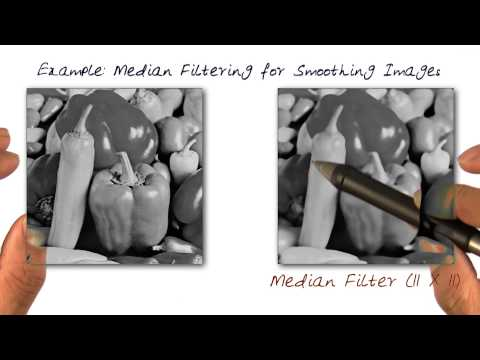

In [32]:
from IPython.display import YouTubeVideo
YouTubeVideo("3ELsNs4ERY8",width=640,height=360)

-----
### Congratulations, you are done!

Submit your tgz file to the course Desire2Learn page in the HW2 assignment.  

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----